
**Created by:**

__[Viktor Varga](https://github.com/vvarga90)__

<br>

<img src="https://docs.google.com/uc?export=download&id=1WzgXsCoz8O-NeBlJTbuLPC1iIFDmgYt1" style="display:inline-block">
<hr>

# Neuronhálók által tanult hipotézisfüggvények vizualizációja

**Megjegyzés:** A notebook szerkeszthetővé és futtathatóvá válik a File menü -> "Open in playground mode" kiválasztása után, vagy a notebook le is másolható a saját Drive-ra a "Save a copy in Drive" funkcióval: ez a másolat ugyancsak szerkeszthető és futtatható lesz.

Ebben a notebookban arra mutatunk példát, hogy neuronhálók által tanult klasszifikációs döntési felületek komplexitása hogyan nő, ha növeljük a neuronok számát a teljesen összekötött rétegekben. Ha növeljük a neuronok számát egy rétegben, növeljük a vektortér dimenzióját, azaz a döntési felületeink magasabb dimenziós térben tanulhatók, ami előnyös lehet.

In [ ]:
%tensorflow_version 2.x
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets
import tensorflow as tf
import tensorflow.keras.models
import tensorflow.keras.optimizers
import tensorflow.keras.layers

Először, generáljunk olyan kétváltozós mintát két címkével, ahol a különböző címkékkel ellátott mintaelemek két dimenzióban nem szeparálhatóak lineárisan, azaz nem húzható be olyan hipersík (egyenes) ami elválasztja a különböző címkéjű mintaelemeket hiba nélkül.

(100, 2)
(100,)


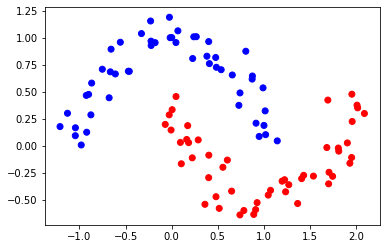

In [ ]:
xs, ys = sklearn.datasets.make_moons(n_samples=100, noise=0.1)
print(xs.shape)   # 2D samples: (x1,x2)
print(ys.shape)   # labels of samples: 0 or 1
plt.scatter(xs[:,0], xs[:,1], c=['r' if y == 1 else 'b' for y in ys])  # red for label 1, blue for 0
plt.show();

Alább három Python függvényt definiálunk.

Az első a Keras neuronháló-könyvtár segítségével elkészíti a modellünket, egy teljesen összekötött neuronhálót (ez a hipotézisfüggvény), megad hozzá egy _optimizer_-t (azaz egy gradiens-módszer alapú optimizáló algoritmust), a használandó loss (költség) függvényt és a keras.models.Model.compile() függvény segítségével utasítást ad az előtte definiált számítási gráf hatékonyabb kódra (C++, CUDA, ...) történő lefordítására.

A második a keras.models.Model.fit() függvény többszöri hívásával adott számú iterációt végez el a gradiens módszeres optimalizációból. A hálónkat addig tanítja, amíg az _accuracy_ a tanítóhalmazon javul. Validációs és teszt halmaz használatától ezúttal eltekintünk.

A harmadik függvény kirajzolja a betanult neuronháló által tanult hipotézisfüggvény értékét az inputváltozók függvényében és megjelöli rajta a döntési felületet (piros vonal).

In [ ]:
def createMLP(n_layers, n_neurons_per_layer, activation='sigmoid', learning_rate=.001):
  assert n_layers < 10, "Too many layers!"
  assert n_neurons_per_layer < 1000, "Too many neurons!"
  assert activation in ['sigmoid', 'tanh', 'relu']

  layer_inp = tf.keras.layers.Input(shape=(2,))
  layer = layer_inp
  for layer_idx in range(n_layers-1):
    layer = tf.keras.layers.Dense(n_neurons_per_layer, activation=activation)(layer)
  layer_out = tf.keras.layers.Dense(1, activation='sigmoid')(layer)
  model = tf.keras.models.Model(inputs=[layer_inp], outputs=[layer_out])

  #opt = keras.optimizers.SGD(learning_rate=.01)
  opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model


def trainModel(model, xs, ys):
  prev_acc = 0.
  n_epochs_in_iter = 2000

  for iter_idx in range(10):
    hs = model.fit(xs, ys, epochs=n_epochs_in_iter, batch_size=512, verbose=0)

    # break loop if accuracy stopped improving
    print(list(hs.history.keys()))
    print(str(n_epochs_in_iter*(iter_idx+1)) + " iterations done. Loss & accuracy are: " + str(hs.history['loss'][-1]) + ", " + str(hs.history['accuracy'][-1]))
    if hs.history['accuracy'][-1] < prev_acc*1.01:
      break
    else:
      prev_acc = hs.history['accuracy'][-1]


def plotPredictions(model, xs_train, ys_train):
  # xs_train shape: (n, 2)
  n_ps = 100
  x1 = np.linspace(np.amin(xs_train[:,0]), np.amax(xs_train[:,0]), num=n_ps)
  x2 = np.linspace(np.amin(xs_train[:,1]), np.amax(xs_train[:,1]), num=n_ps)
  xx1, xx2 = np.meshgrid(x1, x2)
  xs_eval = np.stack([xx1, xx2], axis=-1).reshape((-1, 2))  # (n, 2)

  ys_pred = model.predict(xs_eval)   # (n,)
  ys_pred = ys_pred.reshape((n_ps, n_ps))

  plt.figure()
  CS = plt.pcolormesh(xx1, xx2, ys_pred)
  plt.scatter(xs_train[:,0], xs_train[:,1], c=['r' if y == 1 else 'b' for y in ys_train])  # red for label 1, blue for 0
  plt.contour(xx1, xx2, ys_pred, levels=[0.5, 1.5], colors='r')
  plt.colorbar(CS)
  plt.xlabel("x_1")
  plt.ylabel("x_2")
  plt.title("y")
  plt.show();

Generálunk egy egyrétegű neuronhálót egyetlen neuronnal (rejtett réteg nélkül). Ez egy logisztikus regressziónak felel meg. Tanítjuk a modellt és kirajzoljuk a tanult hipotézisfüggvényt. Látható, hogy egy logisztikus regresszió kizárólag lineáris szeparációt képes tanulni.

['loss', 'accuracy']
2000 iterations done. Loss & accuracy are: 0.32527676224708557, 0.8299999833106995
['loss', 'accuracy']
4000 iterations done. Loss & accuracy are: 0.2572372555732727, 0.8799999952316284
['loss', 'accuracy']
6000 iterations done. Loss & accuracy are: 0.2385159432888031, 0.8799999952316284


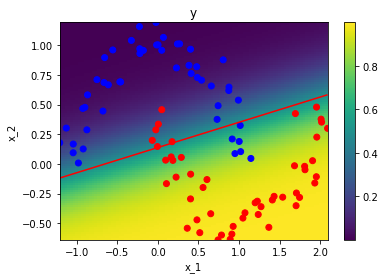

In [ ]:
model_simple = createMLP(1, 2, activation='sigmoid')
trainModel(model_simple, xs, ys)
plotPredictions(model_simple, xs, ys)

Most egy nagyobb hálóval tanuljuk ugynazt a mintát.

['loss', 'accuracy']
2000 iterations done. Loss & accuracy are: 0.12044765800237656, 0.949999988079071
['loss', 'accuracy']
4000 iterations done. Loss & accuracy are: 0.024965176358819008, 1.0
['loss', 'accuracy']
6000 iterations done. Loss & accuracy are: 0.0037759291008114815, 1.0


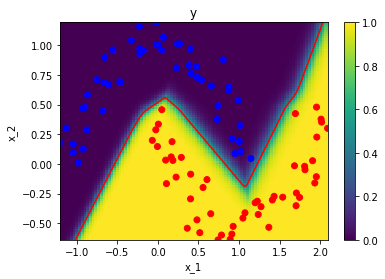

In [ ]:
model_better = createMLP(2, 20, activation='relu')
trainModel(model_better, xs, ys)
plotPredictions(model_better, xs, ys)

Generáljunk most olyan mintát, amit még nehezebb helyesen klasszifikálni.

(500, 2)
(500,)


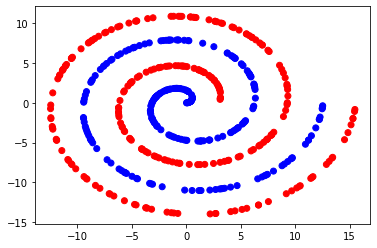

In [ ]:
ys2 = np.random.randint(2, size=(500,))
t = 4. * np.pi * (np.random.rand(ys2.shape[0]))

radd = np.zeros_like(ys2, dtype=np.float32)
radd[ys2 == 1] = 3.
xs2 = np.stack([(t+radd) * np.cos(t), (t+radd) * np.sin(t)], axis=-1)
print(xs2.shape)
print(ys2.shape)

plt.scatter(xs2[:,0], xs2[:,1], c=['r' if y == 1 else 'b' for y in ys2])  # red for label 1, blue for 0
plt.show();


Megpróbáljuk az előző, kétrétegű hálónkkal megtanulni klasszifikálni a bonyolultabb mintát. Látható, hogy nem sikerül túl jól.

['loss', 'accuracy']
2000 iterations done. Loss & accuracy are: 0.5479089617729187, 0.5960000157356262
['loss', 'accuracy']
4000 iterations done. Loss & accuracy are: 0.5399690866470337, 0.6140000224113464
['loss', 'accuracy']
6000 iterations done. Loss & accuracy are: 0.5361597537994385, 0.6320000290870667
['loss', 'accuracy']
8000 iterations done. Loss & accuracy are: 0.5343289375305176, 0.6480000019073486
['loss', 'accuracy']
10000 iterations done. Loss & accuracy are: 0.5333192348480225, 0.656000018119812
['loss', 'accuracy']
12000 iterations done. Loss & accuracy are: 0.5324158668518066, 0.6620000004768372


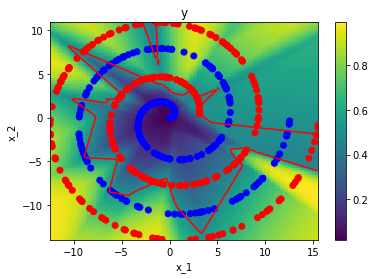

In [ ]:
model_better = createMLP(2, 20, activation='relu', learning_rate=0.001)
trainModel(model_better, xs2, ys2)
plotPredictions(model_better, xs2, ys2)

Adjunk még hozzá két réteget! A tanult modell sokkal jobb eredményt ad, sőt, egyes helyeken már a túltanulás jelei mutatkoznak (hiszen nem használtunk validációs halmazt és early stopping-ot).

['loss', 'accuracy']
2000 iterations done. Loss & accuracy are: 0.30786165595054626, 0.8659999966621399
['loss', 'accuracy']
4000 iterations done. Loss & accuracy are: 0.011830727569758892, 0.9959999918937683
['loss', 'accuracy']
6000 iterations done. Loss & accuracy are: 0.0001746696070767939, 1.0


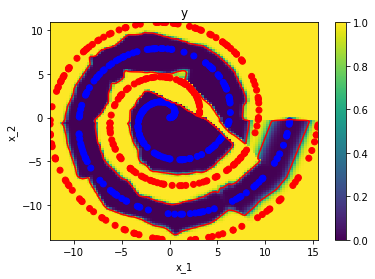

In [ ]:
model_better = createMLP(4, 20, activation='relu', learning_rate=0.001)
trainModel(model_better, xs2, ys2)
plotPredictions(model_better, xs2, ys2)